# Res-LeNet + cifar10数据集

## 1.定义残差块

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    # 前向传播
    def forward(self, X):
        # 主路径
        # 卷积1 → 批归一化1 → ReLU激活
        Y = F.relu(self.bn1(self.conv1(X)))
        # 卷积2 → 批归一化2
        Y = self.bn2(self.conv2(Y))

        # 捷径
        if self.conv3:
            X = self.conv3(X)  # 使用了1*1的卷积核则先调整X的大小
        
        # 合并主路径和捷径
        Y += X
        return F.relu(Y)  # 激活

## 2.构建残差网络

In [2]:
# 定义ResNet-LeNet混合模型
class ResLeNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # 初始卷积层（LeNet的第一层）
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.sigmoid = nn.Sigmoid()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        # 插入残差块
        self.resblock1 = Residual(32, 32)  # 通道数不变（32 → 32）
        self.resblock2 = Residual(32, 64, use_1x1conv=True, strides=2)  # 降采样（32 → 64）

        # LeNet的第二卷积层（替换为残差块后不再需要单独定义）
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        # 计算全连接层输入维度（假设输入图像为32x32）
        # 经过conv1 + pool1: 32x32 → 16x16
        # 经过resblock2（strides=2）: 16x16 → 8x8
        # 经过pool2: 8x8 → 4x4
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 4 * 4, 256)  # 64通道，4x4特征图
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, X):
        # 初始卷积 + Sigmoid + 池化
        X = self.pool1(self.sigmoid(self.conv1(X)))  # [batch, 32, 16, 16]

        # 残差块
        X = self.resblock1(X)  # [batch, 32, 16, 16]
        X = self.resblock2(X)  # [batch, 64, 8, 8]（降采样）

        # 池化
        X = self.pool2(X)  # [batch, 64, 4, 4]

        # 全连接层
        X = self.flatten(X)
        X = self.sigmoid(self.fc1(X))
        X = self.fc2(X)
        return X

In [3]:
# 创建模型实例
model = ResLeNet(num_classes=10)
print(model)

ResLeNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (sigmoid): Sigmoid()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (resblock1): Residual(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (resblock2): Residual(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool2): AvgPool2d(kernel_size=

## 2.加载数据集

In [4]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# 定义批量大小
batch_size = 256

# 数据预处理（标准化参数来自 CIFAR-10 的官方统计）
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10 的RGB均值
                        std=[0.2470, 0.2435, 0.2616])    # CIFAR-10 的RGB标准差
])

# 加载训练集和测试集
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# 创建数据迭代器
train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## 3.训练模型

loss 0.007, train acc 1.000, test acc 0.782
44288.1 examples/sec on cuda:0


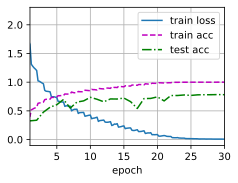

In [9]:
# 初始化模型
# net = ResNet().to(d2l.try_gpu())
# 训练模型
lr, num_epochs, batch_size = 0.5, 30, 512
d2l.train_ch6(model, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 4.参数量查看

In [11]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
ResLeNet                                 --
├─Conv2d: 1-1                            896
├─Sigmoid: 1-2                           --
├─AvgPool2d: 1-3                         --
├─Residual: 1-4                          --
│    └─Conv2d: 2-1                       9,248
│    └─Conv2d: 2-2                       9,248
│    └─BatchNorm2d: 2-3                  64
│    └─BatchNorm2d: 2-4                  64
├─Residual: 1-5                          --
│    └─Conv2d: 2-5                       18,496
│    └─Conv2d: 2-6                       36,928
│    └─Conv2d: 2-7                       2,112
│    └─BatchNorm2d: 2-8                  128
│    └─BatchNorm2d: 2-9                  128
├─AvgPool2d: 1-6                         --
├─Flatten: 1-7                           --
├─Linear: 1-8                            262,400
├─Linear: 1-9                            2,570
Total params: 342,282
Trainable params: 342,282
Non-trainable params: 0

## 5.比较LeNet和Res-LeNet
<b>训练集准确率：</b>经过足够多轮次的训练，LeNet和Res-LeNet在训练集上的准确度均达到了1.0<br><br>
<b>测试集准确率：</b>经过足够多轮次的训练，两个网络模型在测试集上的准确度均已稳定，学习率为0.99的情况下，LeNet的最高测试集准确度为0.649；学习率为0.01的情况下，Res-LeNet的最高测试集准确度为0.661。能够看出，达到稳定时，Res-LeNet的准确度要高于LeNet，说明加入残差块对准确度起到了积极的影响。<br><br>
<b>训练轮次：</b>通过输出结果可以看出，LeNet需要训练大约60轮才能稳定收敛，Res-LeNet只需要训练25轮左右即可收敛。<br><br>
<b>参数量：</b>LeNet所需要的参数量为825K，Res-LeNet所需要的参数量为342K，Res-LeNet收敛更快，准确度也更高，参数量也更少，整体效果均优于LeNet。<br><br>
<b>结果理解与分析：</b>经实验，在加入残差块之后，参数量更少，占用内存空间更少，同时训练的准确度、效果显著提升，达到近似LeNet的训练结果所需要的训练轮次也更少，收敛速度明显增快。整体来说，加入残差块进行前向传播，优化了整体架构，能够利用有限的资源更加高效地达到预期的训练效果。